In [ ]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore

In [ ]:

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050) 

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis=0)
    
    return mfccs

data = []
labels = []


In [3]:
emotion_map = {
    0: 'neutral',
    1: 'calm',
    2: 'happy',
    3: 'sad',
    4: 'angry',
    5: 'fearful',
    6: 'disgust',
    7: 'surprised'
}

In [ ]:
# ravdess_path = r"C:\Users\sbhar\Downloads\Ravdess_audio"  
ravdess_path = r"C:\Users\sbhar\Downloads\Ravdess_audio\audio_speech_actors_01-24"  

for root, dirs, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith('.wav') and file.startswith('03-01'):
            file_path = os.path.join(root, file)
            
            emotion_code = int(file.split('-')[2])
            labels.append(emotion_code - 1) 

            features = extract_features(file_path)
            data.append(features)

X = np.array(data)
y = np.array(labels)

print("Unique labels:", np.unique(y))

Unique labels: [0 1 2 3 4 5 6 7]


In [25]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN input (samples, features, channels)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
input_shape = (X_scaled.shape[1], 1)  # Add channel dimension (required for Conv1D)
num_classes = len(np.unique(y))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,504 (166.03 KB)

 Trainable params: 42,504 (166.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model = models.load_model(r"trained_models\\audio_emotion_detection.keras") 

In [ ]:
history = model.fit( 
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),  
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9513 - loss: 0.1474 - val_accuracy: 0.9887 - val_loss: 0.0433
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9658 - loss: 0.1104 - val_accuracy: 0.9991 - val_loss: 0.0227
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9618 - loss: 0.1214 - val_accuracy: 0.9931 - val_loss: 0.0381
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9641 - loss: 0.1063 - val_accuracy: 0.9983 - val_loss: 0.0214
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9628 - loss: 0.1067 - val_accuracy: 0.9965 - val_loss: 0.0252
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9661 - loss: 0.1108 - val_accuracy: 0.9965 - val_loss: 0.0209
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9673 - loss: 0.1077 - val_accuracy: 0.9931 - val_loss: 0.0299
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.1155 - val_accuracy: 0.

In [50]:
# Evaluate the model
test_loss , test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9963 - loss: 0.0210 
Test Loss: 0.022631751373410225, Test Accuracy: 0.9947916865348816


In [48]:
model.save("audio_emotion_detection.keras",overwrite=True)

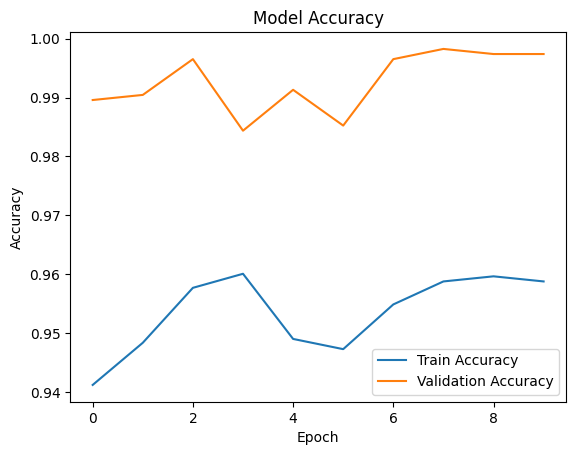

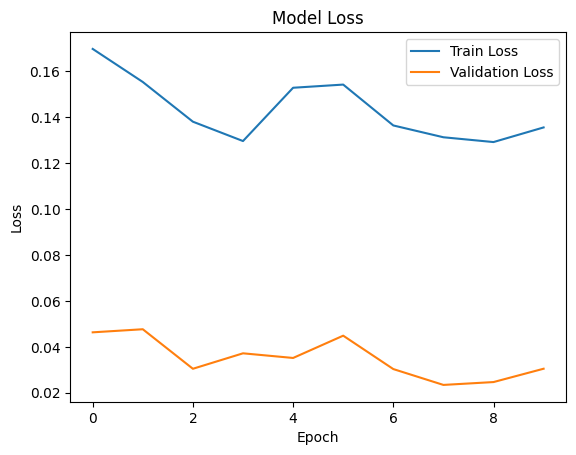

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# code